# Figure 2 (Baseline Analysis)

In [1]:
import os

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

In [2]:
# Replace with the path to where you store data
DATA_PATH = "../../cnt-data/"

In [3]:
# This is the example patient's HUP ID
patient_hup_id = 142

# Load in the patient's "giant table"
hourly_patient_features_df = pd.read_csv(
    os.path.join(DATA_PATH, f"giant_new_tables/HUP_{str(patient_hup_id)}.csv")
)

## Figure 2 (C)

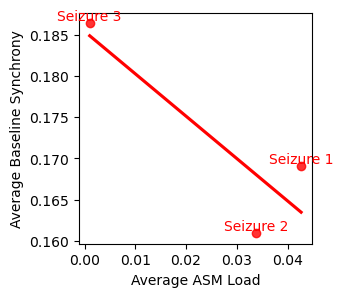

In [4]:
# Assuming you have the hourly_patient_features_df from somewhere above
seizure_indices = hourly_patient_features_df[
    hourly_patient_features_df["had_seizure"] >= 1
].index

valid_seizure_indices = [
    idx
    for i, idx in enumerate(seizure_indices)
    if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 120
]

avg_synchronies = []
avg_med_loads = []

for idx in valid_seizure_indices:
    seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

    window = hourly_patient_features_df[
        (hourly_patient_features_df["emu_minute"] >= seizure_time - 120)
        & (hourly_patient_features_df["emu_minute"] < seizure_time - 20)
    ]

    avg_synchrony = np.nanmean(window["synchrony_broadband"])
    avg_med_load = np.nanmean(window["med_sum_no_lorazepam_raw"])

    avg_synchronies.append(avg_synchrony)
    avg_med_loads.append(avg_med_load)

if avg_med_loads and avg_synchronies:
    plt.figure(figsize=(3, 3))  # Add this line to create a standalone figure
    sns.regplot(
        x=avg_med_loads,
        y=avg_synchronies,
        scatter=True,
        line_kws={"color": "red"},
        ci=None,
        color="red",
    )

    # Label each dot with its respective seizure number
    for i, (x, y) in enumerate(zip(avg_med_loads, avg_synchronies)):
        plt.text(
            x, y, f"Seizure {i+1}", fontsize=10, ha="center", va="bottom", color="red"
        )

    plt.xlabel("Average ASM Load")
    plt.ylabel("Average Baseline Synchrony")
    # plt.title(f"Baseline Synchrony vs ASM")
    plt.show()  # Add this line to display the plot

## Figure 2 (D)

In [5]:
def get_patient_hup_ids(directory):
    # List all files in the directory
    files = os.listdir(directory)

    # Filter out files based on the given pattern and extract patient_hup_id as integers
    patient_hup_ids = [
        int(f.split("_")[1].split(".")[0]) for f in files if f.startswith("HUP_")
    ]

    return patient_hup_ids


TABLES_PATH = os.path.join(DATA_PATH, "giant_new_tables")
completed_hup_ids = get_patient_hup_ids(TABLES_PATH)
completed_hup_ids.sort()

In [6]:
completed_hup_ids

[137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 177,
 178,
 179,
 180,
 181,
 182,
 184,
 185,
 186,
 187,
 188,
 189,
 190,
 191,
 192,
 193,
 196,
 199,
 202,
 204,
 205,
 206,
 207,
 210,
 217,
 219,
 221,
 223,
 225]

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     104.7
Date:                Sat, 22 Feb 2025   Prob (F-statistic):           2.69e-24
Time:                        18:28:05   Log-Likelihood:                 8543.6
No. Observations:                4440   AIC:                        -1.708e+04
Df Residuals:                    4438   BIC:                        -1.707e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1274      0.001    160.909      0.0

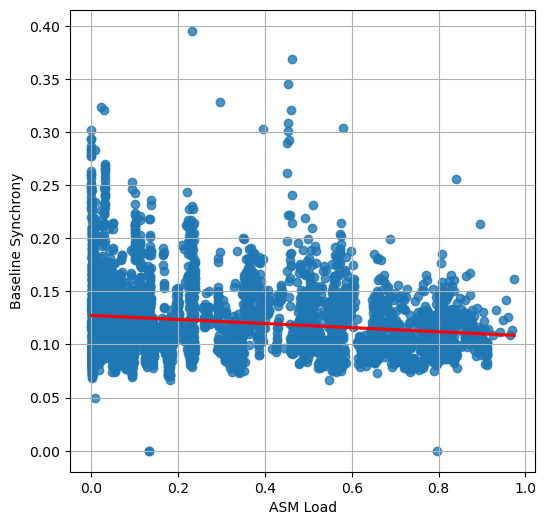

In [7]:
def get_seizure_data(hourly_patient_features_df):
    """
    For a given hourly_patient_features_df, return a list of tuples.
    Each tuple contains the original ASM load and synchrony values from
    the window preceding each seizure, for values where synchrony < 0.6.
    """
    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 5 * 60
    ]

    seizure_data = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]
        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip if no valid synchrony values

        # Instead of computing median values, iterate over each row in the window
        for _, row in window.iterrows():
            if row["synchrony_broadband"] < 0.6:
                seizure_data.append(
                    (row["med_sum_no_lorazepam_raw"], row["synchrony_broadband"])
                )

    return seizure_data


# Accumulate data from all patients
all_seizures_data = []

for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )
    all_seizures_data.extend(get_seizure_data(hourly_patient_features_df))

# Scatter plot
plt.figure(figsize=(6, 6))
asm_loads, synchronies = zip(*all_seizures_data)

# Convert tuples to lists
asm_loads_list = list(asm_loads)
synchronies_list = list(synchronies)

# Fit an OLS regression model
X = sm.add_constant(asm_loads_list)  # Adding a constant for the intercept
model = sm.OLS(synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=asm_loads_list,
    y=synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

plt.xlabel("ASM Load")
plt.ylabel("Baseline Synchrony")
plt.grid(True)
plt.show()

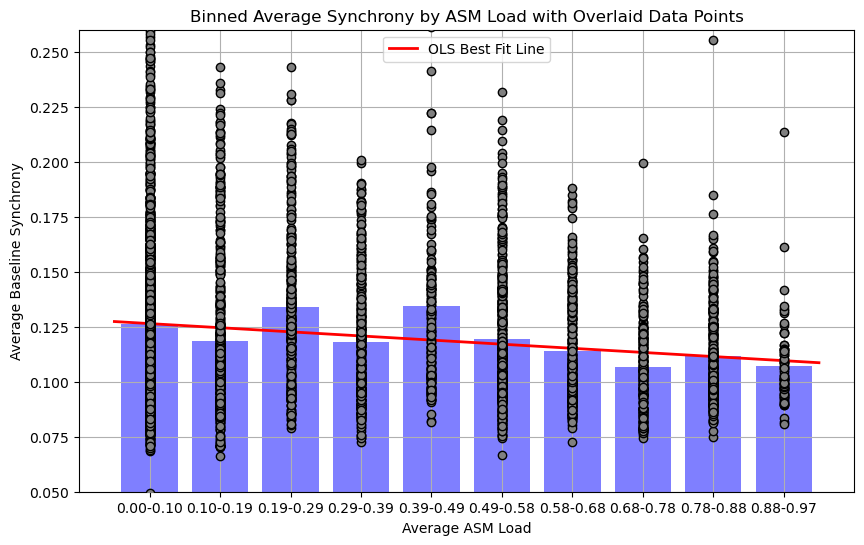

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
x = np.array(asm_loads_list)
y = np.array(synchronies_list)

# Determine the range of x values
x_min = np.min(x)
x_max = np.max(x)

# Define 10 windows (bins) using linspace to span from x_min to x_max
bins = np.linspace(x_min, x_max, 11)  # 11 edges for 10 bins

bin_centers = []
bin_avg_synchrony = []
bin_labels = []

plt.figure(figsize=(10, 6))

# Loop over each bin interval
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]

    # Create a label for the bin
    label = f"{lower:.2f}-{upper:.2f}"
    bin_labels.append(label)

    # Calculate the center of the current bin
    center = (lower + upper) / 2
    bin_centers.append(center)

    # Create a mask for values in the current bin [lower, upper)
    bin_mask = (x >= lower) & (x < upper)
    # For the last bin, include the upper edge
    if i == len(bins) - 2:
        bin_mask = (x >= lower) & (x <= upper)

    # Calculate the average synchrony for points in this bin;
    # if no points, set avg_sync to 0 so the bar height is zero
    if np.any(bin_mask):
        avg_sync = np.nanmean(y[bin_mask])
    else:
        avg_sync = 0
    bin_avg_synchrony.append(avg_sync)

    # Plot the bar for this bin with reduced width (80% of the bin width) for spacing
    bar_width = 0.8 * (upper - lower)
    plt.bar(center, avg_sync, width=bar_width, color="blue", alpha=0.5)

    # Overlay the individual data points in this bin, but force the x-values to the bin center
    # so they are horizontally centered around the bar.
    plt.scatter(
        np.full(np.sum(bin_mask), center),
        y[bin_mask],
        color="grey",
        edgecolor="black",
        zorder=5,
    )

# Compute the OLS best fit line for all individual data points
m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(x_min, x_max, 100)
y_fit = m * x_fit + b
plt.ylim(0.05, 0.26)
plt.plot(x_fit, y_fit, color="red", linewidth=2, label="OLS Best Fit Line")

# Set the x-axis ticks to show the bin ranges
plt.xticks(bin_centers, bin_labels)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.title("Binned Average Synchrony by ASM Load with Overlaid Data Points")
plt.legend()
plt.grid(True)
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.712
Date:                Sat, 22 Feb 2025   Prob (F-statistic):             0.0315
Time:                        18:28:06   Log-Likelihood:                 325.83
No. Observations:                 154   AIC:                            -647.7
Df Residuals:                     152   BIC:                            -641.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1253      0.004     35.616      0.0

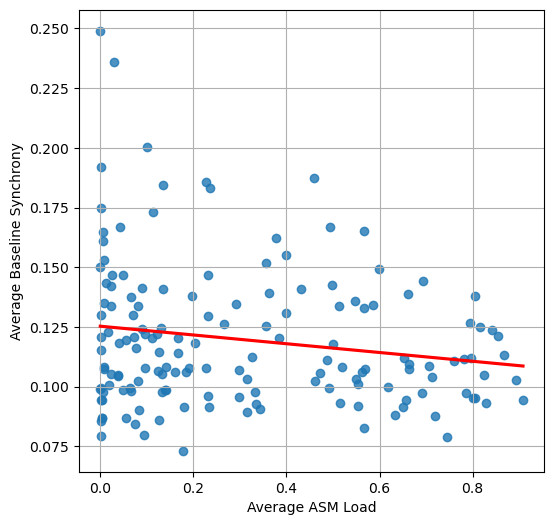

In [8]:
def get_seizure_data(hourly_patient_features_df):
    """
    For a given hourly_patient_features_df, return a list of tuples.
    Each tuple contains avg_med_load and avg_synchrony for each seizure.
    """
    seizure_indices = hourly_patient_features_df[
        hourly_patient_features_df["had_seizure"] >= 1
    ].index

    valid_seizure_indices = [
        idx
        for i, idx in enumerate(seizure_indices)
        if i == 0 or (seizure_indices[i] - seizure_indices[i - 1]) >= 5 * 60
    ]

    seizure_data = []

    for idx in valid_seizure_indices:
        seizure_time = hourly_patient_features_df.loc[idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]
        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmedian(window["synchrony_broadband"])
        avg_med_load = np.nanmedian(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            seizure_data.append((avg_med_load, avg_synchrony))

    return seizure_data


# Accumulate data from all patients
all_seizures_data = []

for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )
    all_seizures_data.extend(get_seizure_data(hourly_patient_features_df))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)

# Convert tuples to lists
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()

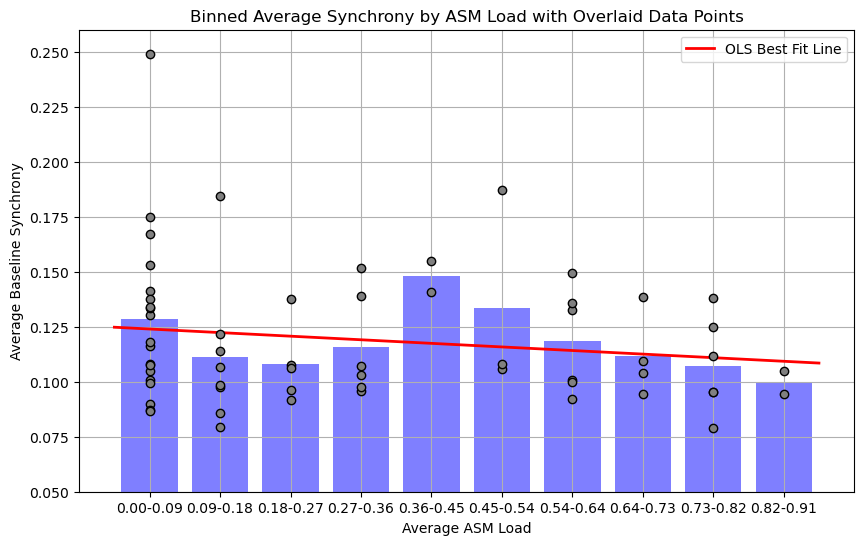

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Convert lists to numpy arrays
x = np.array(avg_med_loads_list)
y = np.array(avg_synchronies_list)

# Determine the range of x values
x_min = np.min(x)
x_max = np.max(x)

# Define 10 windows (bins) using linspace to span from x_min to x_max
bins = np.linspace(x_min, x_max, 11)  # 11 edges for 10 bins

bin_centers = []
bin_avg_synchrony = []
bin_labels = []

plt.figure(figsize=(10, 6))

# Loop over each bin interval
for i in range(len(bins) - 1):
    lower = bins[i]
    upper = bins[i + 1]

    # Create a label for the bin
    label = f"{lower:.2f}-{upper:.2f}"
    bin_labels.append(label)

    # Calculate the center of the current bin
    center = (lower + upper) / 2
    bin_centers.append(center)

    # Create a mask for values in the current bin [lower, upper)
    bin_mask = (x >= lower) & (x < upper)
    # For the last bin, include the upper edge
    if i == len(bins) - 2:
        bin_mask = (x >= lower) & (x <= upper)

    # Calculate the average synchrony for points in this bin;
    # if no points, set avg_sync to 0 so the bar height is zero
    if np.any(bin_mask):
        avg_sync = np.nanmean(y[bin_mask])
    else:
        avg_sync = 0
    bin_avg_synchrony.append(avg_sync)

    # Plot the bar for this bin with reduced width (80% of the bin width) for spacing
    bar_width = 0.8 * (upper - lower)
    plt.bar(center, avg_sync, width=bar_width, color="blue", alpha=0.5)

    # Overlay the individual data points in this bin, but force the x-values to the bin center
    # so they are horizontally centered around the bar.
    plt.scatter(
        np.full(np.sum(bin_mask), center),
        y[bin_mask],
        color="grey",
        edgecolor="black",
        zorder=5,
    )

# Compute the OLS best fit line for all individual data points
m, b = np.polyfit(x, y, 1)
x_fit = np.linspace(x_min, x_max, 100)
y_fit = m * x_fit + b
plt.ylim(0.05, 0.26)
plt.plot(x_fit, y_fit, color="red", linewidth=2, label="OLS Best Fit Line")

# Set the x-axis ticks to show the bin ranges
plt.xticks(bin_centers, bin_labels)

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.title("Binned Average Synchrony by ASM Load with Overlaid Data Points")
plt.legend()
plt.grid(True)
plt.show()

## Figure 2 (E)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     1.668
Date:                Sat, 22 Feb 2025   Prob (F-statistic):              0.202
Time:                        18:28:08   Log-Likelihood:                 127.26
No. Observations:                  61   AIC:                            -250.5
Df Residuals:                      59   BIC:                            -246.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1248      0.006     20.990      0.0

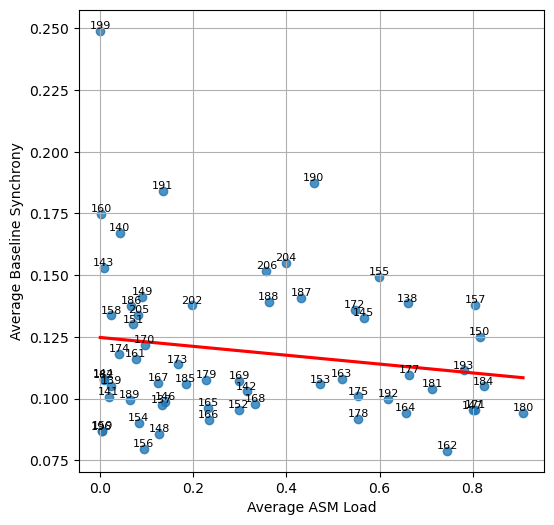

In [10]:
all_seizures_data = []

# Iterate through all patient data
for patient_hup_id in completed_hup_ids:
    hourly_patient_features_df = pd.read_csv(
        os.path.join(TABLES_PATH, f"HUP_{str(patient_hup_id)}.csv")
    )

    # Get only the first seizure index
    first_seizure_idx = (
        hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].index[0]
        if not hourly_patient_features_df[
            hourly_patient_features_df["had_seizure"] >= 1
        ].empty
        else None
    )

    if first_seizure_idx:
        seizure_time = hourly_patient_features_df.loc[first_seizure_idx, "emu_minute"]

        window = hourly_patient_features_df[
            (hourly_patient_features_df["emu_minute"] >= seizure_time - 60)
            & (hourly_patient_features_df["emu_minute"] < seizure_time)
        ]

        if len(window["synchrony_broadband"]) == 0 or np.all(
            np.isnan(window["synchrony_broadband"])
        ):
            continue  # Skip the rest of the current iteration

        avg_synchrony = np.nanmedian(window["synchrony_broadband"])
        avg_med_load = np.nanmedian(window["med_sum_no_lorazepam_raw"])

        if avg_synchrony < 0.6:
            all_seizures_data.append((avg_med_load, avg_synchrony))

# Scatter plot
plt.figure(figsize=(6, 6))
avg_med_loads, avg_synchronies = zip(*all_seizures_data)
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Fit an OLS regression model
X = sm.add_constant(avg_med_loads_list)  # Adding a constant for the intercept
model = sm.OLS(avg_synchronies_list, X).fit()

# Print out the statistics
print(model.summary())

sns.regplot(
    x=avg_med_loads_list,
    y=avg_synchronies_list,
    scatter=True,
    line_kws={"color": "red"},
    ci=None,
)

for i, (x, y) in enumerate(zip(avg_med_loads_list, avg_synchronies_list)):
    plt.text(x, y, f"{completed_hup_ids[i]}", fontsize=8, ha="center", va="bottom")

plt.xlabel("Average ASM Load")
plt.ylabel("Average Baseline Synchrony")
plt.grid(True)
plt.show()

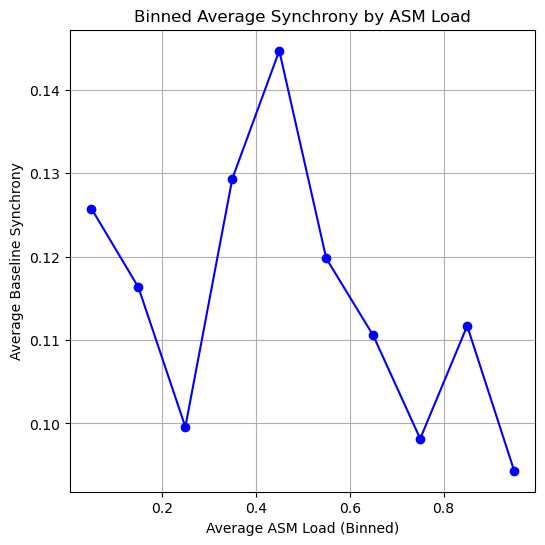

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# After collecting your data:
# all_seizures_data already contains tuples (avg_med_load, avg_synchrony)
avg_med_loads, avg_synchronies = zip(*all_seizures_data)
avg_med_loads_list = list(avg_med_loads)
avg_synchronies_list = list(avg_synchronies)

# Convert lists to numpy arrays for easier manipulation
x = np.array(avg_med_loads_list)
y = np.array(avg_synchronies_list)

# Define bin edges from 0 to 1 in increments of 0.1
bins = np.arange(0, 1.1, 0.1)  # Creates edges: 0.0, 0.1, 0.2, ..., 1.0

bin_centers = []
bin_avg_synchrony = []

# Loop over each bin interval and compute the mean synchrony
for i in range(len(bins) - 1):
    # Create a mask for values in the current bin [bins[i], bins[i+1])
    bin_mask = (x >= bins[i]) & (x < bins[i + 1])

    # Compute the center of the current bin
    center = (bins[i] + bins[i + 1]) / 2
    bin_centers.append(center)

    # Compute the average synchrony for data points in the bin
    if np.any(bin_mask):
        avg_sync = np.nanmean(y[bin_mask])
    else:
        avg_sync = (
            np.nan
        )  # or you could choose to skip the bin if no data points fall in it
    bin_avg_synchrony.append(avg_sync)

# Plot the aggregated (binned) data
plt.figure(figsize=(6, 6))
plt.plot(bin_centers, bin_avg_synchrony, marker="o", linestyle="-", color="blue")
plt.xlabel("Average ASM Load (Binned)")
plt.ylabel("Average Baseline Synchrony")
plt.title("Binned Average Synchrony by ASM Load")
plt.grid(True)
plt.show()